## Measuring g with a Physical Pendulum - Explore
### Load Libraries
Note that I used python uncertainties package to compute uncertainties instead of manual calculation inputting formula.
You would need to do:

**pip install uncertainties**

In [16]:
# For scientific computing
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import factorial
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.integrate as integrate

# For plotting
import matplotlib.pyplot as plt

from uncertainties import ufloat
from uncertainties.umath import *  #e.g. sqrt()
from uncertainties import unumpy

## 1. (1st model) Plot of $T^2$ vs $\frac{k^2 + l^2}{l^2}$

The relationship between T and l we derived is as follows:

$$T = 2\pi \sqrt{\frac{k^2+l^2}{gl}}$$

The linearized equation will be following.

$$T^2 = (\frac{4\pi^2}{g}) \frac{k^2+l^2}{l}$$

where $\frac{4\pi^2}{g}$ is slope.

k is a radius of gyration. 
$$ k = \sqrt{\frac{a^2 + b^2}{12}} $$

Then $g$ will be
$$g = \frac{4\pi^2}{(slope)l} $$


k(computed from dimension) = (28.89 ± 0.01) cm
slope= (0.0411 ± 0.0009) s^2/cm
intercept = (-0.045 ± 0.057) s^2
g = 959.5 ± 21.5 cm/s^2


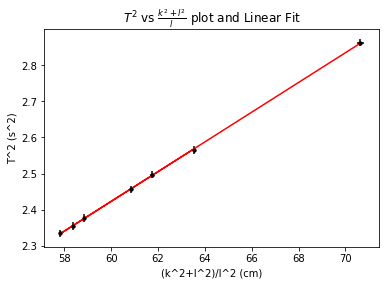

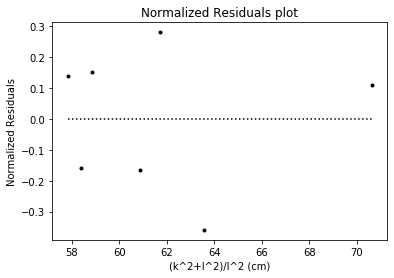

In [17]:
# --------------------------------------------------------------------------------------------------
# Read Data
# --------------------------------------------------------------------------------------------------

#global string for labelling
labely = "T^2 (s^2)"
labelx = "(k^2+l^2)/l^2 (cm)"

#global constants
a = 100  # bar dimension 
b = 3.8  # bar dimension 
c = 0.96  # bar dimension 

#uncertainties 
alpha_a = 0.05 # tape measure precision
alpha_b = 0.05  # ruler precision
alpha_c = 0.005  # vernier caliber precision
alpha_l = 0.05 # ruler precision
alpha_T = 0.01 # photogate precision

a_ufloat = ufloat(a, alpha_a)
b_ufloat = ufloat(b, alpha_b)
k_ufloat = sqrt( (a_ufloat**2 + b_ufloat**2)/12 )

T, l = np.genfromtxt(f"data/2020-11-17-photogate-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')
N = len(T)
l_ufloat = unumpy.uarray(l, alpha_l*np.ones(N))
k = k_ufloat.n

#number of parameters
n = 2

print(f"k(computed from dimension) = ({k_ufloat.n:.2f} ± {k_ufloat.s:.2f}) cm")

# --------------------------------------------------------------------------------------------------
# Fitting
# --------------------------------------------------------------------------------------------------

#inputs
x = ( k**2 + l**2 ) / l
y = T**2

alpha_x = unumpy.std_devs(((k_ufloat**2 + l_ufloat**2)/l_ufloat))
alpha_y = alpha_T * np.ones(N)

def myFunc(x, m, b):
    return m * x + b

pOpt, pCov = curve_fit(myFunc, x, y,
                       p0=[1, 1],
                       sigma=alpha_y,
                       absolute_sigma=True) # abs sigma set to true if y error is known with the samee unit

# Assign each element of pOpt to a named variable
p0_opt = pOpt[0]
p1_opt = pOpt[1]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of pCov
alpha_vec = np.sqrt(np.diag(pCov))

# Assign each element of alpha_vec to a named variable
alpha_p0 = alpha_vec[0]
alpha_p1 = alpha_vec[1]

# ------------------------------------------------------------------------------------
# printing result 
# ------------------------------------------------------------------------------------

# Show optimized fit parameters and uncertainties
slope = p0_opt
intercept = p1_opt

alpha_slope = alpha_p0
alpha_intercept = alpha_p1

slope_ufloat = ufloat(slope, alpha_slope)

print(f"slope= ({slope:.4f} ± {alpha_slope:.4f}) s^2/cm")
print(f"intercept = ({intercept:.3f} ± {alpha_intercept:.3f}) s^2")

g_ufloat = 4 * np.pi**2 / slope_ufloat
print(f"g = {g_ufloat.n:.1f} ± {g_ufloat.s:.1f} cm/s^2")

# ---------------------------------------------------------------
# plotting
# ---------------------------------------------------------------

#Plot data
plt.plot(x, y, 'k.')
plt.plot(x, myFunc(x, p0_opt, p1_opt), 'r-')
plt.errorbar(x, y, xerr=alpha_x, yerr=alpha_y, fmt='k.')
plt.xlabel(f'{labelx}')
plt.ylabel(f'{labely}')
plt.title(r'$T^2$ vs $\frac{k^2+l^2}{l}$ plot and Linear Fit')
plt.show()

# Plot the residuals in a separate figure
plt.plot(x, (y - myFunc(x, p0_opt, p1_opt))/alpha_y, 'k.')
plt.plot([np.min(x), np.max(x)], [0,0], 'k:') #plt.plot([xmin,xmax],[ymin,ymax]) format
plt.xlabel(f"{labelx}")
plt.ylabel('Normalized Residuals')
plt.title(f'Normalized Residuals plot')
plt.show()

## 2. (1st model) Chi-square Analysis for Linearization Method

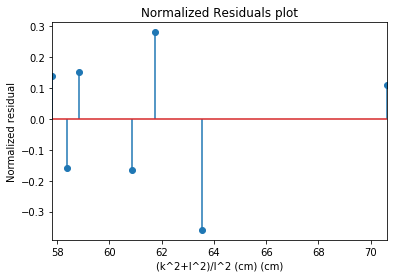

degree of freedom dof = 5
chisq_min = 0.31501
Cumulative probability = 0.002649
Significance: 0.997351
chisq_min is within the range of [v-2*sqrt(2v), v+2*sqrt(2v)] = [-1.324555320336759, 11.32455532033676], so our model is within the 2*sigma range


In [18]:
# --------------------------------------------------------------------------------------------------
# Chi-square analysis
# --------------------------------------------------------------------------------------------------
# Compute and display chi-squared minimum
dof = len(x) - n
res = y - myFunc(x, p0_opt, p1_opt)
normres = res/alpha_y
chisq = np.sum(normres**2)
reduced_chisq = chisq / dof
cdf = chi2.cdf(chisq, dof) # Compute the probability of getting this fit result

# plotting result
plt.stem(x, normres, use_line_collection=True)
plt.xlabel(f'{labelx} (cm)')
plt.ylabel('Normalized residual')
plt.title(f'Normalized Residuals plot')
plt.xlim(np.min(x), np.max(x))
plt.show()

# printing result -------------------------------------------------------------------------
print(f"degree of freedom dof = {dof}")
print(f"chisq_min = {chisq:.5f}")
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance: {1-cdf:.6f}")

if (chisq > dof - np.sqrt(2 * dof) and chisq < dof + np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [{dof - np.sqrt(2 * dof)}, {dof + np.sqrt(2 * dof)}], so our model is within the 1*sigma range")
elif (chisq > dof - 2*np.sqrt(2 * dof) and chisq < dof + 2*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-2*sqrt(2v), v+2*sqrt(2v)] = [{dof - 2*np.sqrt(2 * dof)}, {dof + 2*np.sqrt(2 * dof)}], so our model is within the 2*sigma range")
elif (chisq > dof - 3*np.sqrt(2 * dof) and chisq < dof + 3*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - 3*np.sqrt(2 * dof)}, {dof + 3*np.sqrt(2 * dof)}], so our model is within the 3*sigma range")
else:
    print(f"chisq_min is not within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - np.sqrt(3 * dof)}, {dof + np.sqrt(3 * dof)}], so our model is not within the 3*sigma range")
    print(f"null hypothesis is rejected; our model is not accepted.")

## 3. (2nd model) Plot of $T$ vs $l$

The relationship between T and l we derived is as follows:

$$T = 2\pi \sqrt{\frac{k^2+l^2}{gl}}$$

Estimate k and g directly from the `curve_fit`.

k(computed from dimension) = (28.89 ± 0.01) cm
g(true) = 980.7 cm/s^2
k = (28.98 ± 0.40) s^2/cm
g = (980.3 ± 14.8) s^2
Tmin(true) = 1.53
Tmin(experimental) = 1.53+/-0.02


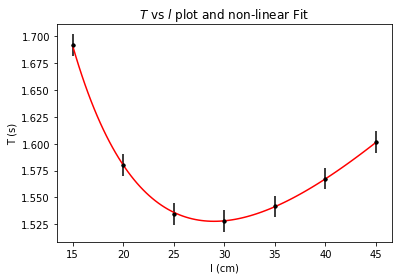

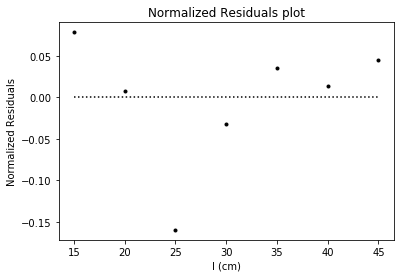

In [21]:
# --------------------------------------------------------------------------------------------------
# Read Data
# --------------------------------------------------------------------------------------------------

#global string for labelling
labely = "T (s)"
labelx = "l (cm)"

#global constants
a = 100  # bar dimension 
b = 3.8  # bar dimension 
c = 0.96  # bar dimension 
g_true = 980.665 # true value of earth grav constant cm/s^2

#uncertainties 
alpha_a = 0.05 # tape measure precision
alpha_b = 0.05  # ruler precision
alpha_c = 0.005  # vernier caliber precision
alpha_l = 0.05 # ruler precision
alpha_T = 0.01 # photogate precision

a_ufloat = ufloat(a, alpha_a)
b_ufloat = ufloat(b, alpha_b)
k_dim_ufloat = sqrt( (a_ufloat**2 + b_ufloat**2)/12 )

T, l = np.genfromtxt(f"data/2020-11-17-photogate-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')
N = len(T)

#number of parameters
n = 2

# --------------------------------------------------------------------------------------------------
# Fitting
# --------------------------------------------------------------------------------------------------

#inputs
x = l
y = T

alpha_x = alpha_l * np.ones(N)
alpha_y = alpha_T * np.ones(N)

def myFunc(x, k, g):
    return 2 * np.pi * np.sqrt((k**2 + x**2) / (g * x))

pOpt, pCov = curve_fit(myFunc, x, y,
                       p0=[28.89, 980],
                       sigma=alpha_y,
                       absolute_sigma=True
                       ) # abs sigma set to true if y error is known with the samee unit

# Assign each element of pOpt to a named variable
p0_opt = pOpt[0]
p1_opt = pOpt[1]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of pCov
alpha_vec = np.sqrt(np.diag(pCov))

# Assign each element of alpha_vec to a named variable
alpha_p0 = alpha_vec[0]
alpha_p1 = alpha_vec[1]

# ------------------------------------------------------------------------------------
# printing result 
# ------------------------------------------------------------------------------------

# Show optimized fit parameters and uncertainties
print(f"k(computed from dimension) = ({k_dim_ufloat.n:.2f} ± {k_dim_ufloat.s:.2f}) cm")
print(f"g(true) = {g_true:.1f} cm/s^2")
print(f"k = ({p0_opt:.2f} ± {alpha_p0:.2f}) s^2/cm")
print(f"g = ({p1_opt:.1f} ± {alpha_p1:.1f}) s^2")

k_exp_ufloat = ufloat(p0_opt, alpha_p0)
g_ufloat = ufloat(p1_opt, alpha_p1)
T_min_true = 2 * np.pi * np.sqrt( (2 * k_dim_ufloat.n)/ g_true)
T_min_ufloat = 2 * np.pi * sqrt( (2 * k_exp_ufloat)/ g_ufloat)
print(f"Tmin(true) = {T_min_true:.2f}")
print(f"Tmin(experimental) = {T_min_ufloat:.2f}")

# ---------------------------------------------------------------
# plotting
# ---------------------------------------------------------------

#Plot data
plt.plot(x, y, 'k.')
x_model = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_model, myFunc(x_model, p0_opt, p1_opt), 'r-')
plt.errorbar(x, y, xerr=alpha_x, yerr=alpha_y, fmt='k.')
plt.xlabel(f'{labelx}')
plt.ylabel(f'{labely}')
plt.title(r'$T$ vs $l$ plot and non-linear Fit')
plt.show()

# Plot the residuals in a separate figure
plt.plot(x, (y - myFunc(x, p0_opt, p1_opt))/alpha_y, 'k.')
plt.plot([np.min(x), np.max(x)], [0,0], 'k:') #plt.plot([xmin,xmax],[ymin,ymax]) format
plt.xlabel(f"{labelx}")
plt.ylabel('Normalized Residuals')
plt.title(f'Normalized Residuals plot')
plt.show()

## 4. (2nd model) Chi-square Analysis for non-linear fitting method

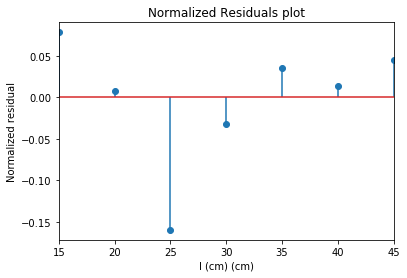

degree of freedom dof = 5
chisq_min = 0.03615
Cumulative probability = 0.000013
Significance: 0.999987
chisq_min is within the range of [v-2*sqrt(2v), v+2*sqrt(2v)] = [-1.324555320336759, 11.32455532033676], so our model is within the 2*sigma range


In [22]:
# --------------------------------------------------------------------------------------------------
# Chi-square analysis
# --------------------------------------------------------------------------------------------------
# Compute and display chi-squared minimum
dof = len(x) - n
res = y - myFunc(x, p0_opt, p1_opt)
normres = res/alpha_y
chisq = np.sum(normres**2)
reduced_chisq = chisq / dof
cdf = chi2.cdf(chisq, dof) # Compute the probability of getting this fit result

# plotting result
plt.stem(x, normres, use_line_collection=True)
plt.xlabel(f'{labelx} (cm)')
plt.ylabel('Normalized residual')
plt.title(f'Normalized Residuals plot')
plt.xlim(np.min(x), np.max(x))
plt.show()

# printing result -------------------------------------------------------------------------
print(f"degree of freedom dof = {dof}")
print(f"chisq_min = {chisq:.5f}")
print(f"Cumulative probability = {cdf:.6f}")
print(f"Significance: {1-cdf:.6f}")

if (chisq > dof - np.sqrt(2 * dof) and chisq < dof + np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-sqrt(2v), v+sqrt(2v)] = [{dof - np.sqrt(2 * dof)}, {dof + np.sqrt(2 * dof)}], so our model is within the 1*sigma range")
elif (chisq > dof - 2*np.sqrt(2 * dof) and chisq < dof + 2*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-2*sqrt(2v), v+2*sqrt(2v)] = [{dof - 2*np.sqrt(2 * dof)}, {dof + 2*np.sqrt(2 * dof)}], so our model is within the 2*sigma range")
elif (chisq > dof - 3*np.sqrt(2 * dof) and chisq < dof + 3*np.sqrt(2 * dof)):
    print(f"chisq_min is within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - 3*np.sqrt(2 * dof)}, {dof + 3*np.sqrt(2 * dof)}], so our model is within the 3*sigma range")
else:
    print(f"chisq_min is not within the range of [v-3*sqrt(2v), v+3*sqrt(2v)] = [{dof - np.sqrt(3 * dof)}, {dof + np.sqrt(3 * dof)}], so our model is not within the 3*sigma range")
    print(f"null hypothesis is rejected; our model is not accepted.")